In [1]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin
from itertools import groupby
import itertools
from sklearn.model_selection import KFold
from  tqdm import  tqdm
from sklearn.metrics import recall_score, f1_score, precision_score
import matplotlib.pyplot as plt

In [2]:
class ConstantConsumptionClassifierWide(BaseEstimator, ClassifierMixin):
    def __init__(self, min_count_constante):
        self.min_count_constante = min_count_constante
        
    def fit(self, X, y=None):
        return self
    
    def len_max_consumo_constante_seg(self,consumo):
        g = [[k, len(list(v))] for k, v in groupby(consumo)]
        g = [x for x in g if (x[1] >= self.min_count_constante)]
        if any(g):
            return 1
        else:
            return 0

    def predict(self, X):
        pred = X.apply(lambda x : self.len_max_consumo_constante_seg(x.values),axis=1)
        return pred

## Leer datos <a class="anchor" id="leer-csv"></a>

In [3]:
%%time
filename = '../../data/clean_data/eegsa_wide_train_data.parquet'
df = pd.read_parquet(filename)
df.shape

CPU times: user 148 ms, sys: 44.4 ms, total: 193 ms
Wall time: 126 ms


(30932, 37)

In [4]:
df.rename(columns={'id_usuario':'uc'}, inplace=True)
df.rename(columns={'id':'index'}, inplace=True)
df.rename(columns={'is_fraud':'target'}, inplace=True)

## Particion Train - Test

In [5]:
# Por fechas 
df_train = df[df.date_fizcalizacion<='2022-02-01'].copy()
df_test = df[df.date_fizcalizacion>'2022-02-01'].copy()
cols_to_model = [str(i)+'_anterior' for i in range(1,13)][::-1]
cols_to_model

['12_anterior',
 '11_anterior',
 '10_anterior',
 '9_anterior',
 '8_anterior',
 '7_anterior',
 '6_anterior',
 '5_anterior',
 '4_anterior',
 '3_anterior',
 '2_anterior',
 '1_anterior']

In [6]:
df_train['all_cero'] = (df_train[cols_to_model].sum(axis=1)==0).astype(int)
df_test['all_cero'] = (df_test[cols_to_model].sum(axis=1)==0).astype(int)
X = df_train[df_train.all_cero==0][cols_to_model].copy()
y = df_train[df_train.all_cero==0].target.copy()

X_test = df_test[df_test.all_cero==0][cols_to_model].copy()
y_test = df_test[df_test.all_cero==0].target.copy()

In [7]:
X = df_train[df_train.all_cero==0][cols_to_model].copy()
y = df_train[df_train.all_cero==0].target.copy()

X_test = df_test[df_test.all_cero==0][cols_to_model].copy()
y_test = df_test[df_test.all_cero==0].target.copy()

## Busqueda de hiperparametros

In [9]:
n_splits = 3
hiper = {'min_count_constante':[3,4,5,6,7,8,9,10]
        }
cofig = list(itertools.product(hiper['min_count_constante']))

In [10]:
#Get K-folds indices
kf = KFold(n_splits = n_splits,shuffle=True, random_state=20)
kf.get_n_splits(X)

# # K-fold cross validation
result = []
for c in tqdm(cofig, total=len(cofig)):
    min_count_constante = c[0]
    const_model = ConstantConsumptionClassifierWide(min_count_constante)
    
    result_p_fold = []
    result_r_fold = []
    result_f1_fold = []
    for train_index, val_index in kf.split(X):
        X_train_fold = X.iloc[train_index, :]
        y_train_fold = y.iloc[train_index]
        # fit and pred
        y_pred = const_model.predict(X_train_fold)
        result_p_fold.append(precision_score(y_train_fold, y_pred))
        result_r_fold.append(recall_score(y_train_fold, y_pred))
        result_f1_fold.append(f1_score(y_train_fold, y_pred))
    
    result_conf = [c[0]] + result_p_fold + result_r_fold + result_f1_fold
    result.append(result_conf)
    
cols_p = ['p_'+str(x) for x in range(kf.get_n_splits(X))]
cols_r = ['r_'+str(x) for x in range(kf.get_n_splits(X))]
cols_f1 = ['f1_'+str(x) for x in range(kf.get_n_splits(X))]
result = pd.DataFrame(result, columns = ['min_count_constante']+cols_p+cols_r+cols_f1)
result['mean_p']=result[cols_p].mean(axis=1)
result['mean_r']=result[cols_r].mean(axis=1)
result['mean_f1']=result[cols_f1].mean(axis=1)

100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


In [11]:
result.sort_values('mean_f1',ascending=False)

,min_count_constante,p_0,p_1,p_2,r_0,r_1,r_2,f1_0,f1_1,f1_2,mean_p,mean_r,mean_f1
4,7,0.019934,0.028939,0.028125,0.065934,0.100000,0.123288,0.030612,0.044888,0.045802,0.025666,0.096407,0.040434
2,5,0.020583,0.025952,0.021849,0.131868,0.166667,0.178082,0.035608,0.044910,0.038922,0.022794,0.158872,0.039814
3,6,0.018561,0.025229,0.024719,0.087912,0.122222,0.150685,0.030651,0.041825,0.042471,0.022837,0.120273,0.038316
1,4,0.015796,0.021303,0.019925,0.142857,0.188889,0.219178,0.028446,0.038288,0.036530,0.019008,0.183641,0.034421
0,3,0.016895,0.021880,0.016194,0.230769,0.300000,0.273973,0.031484,0.040785,0.030581,0.018323,0.268247,0.034284
6,9,0.025478,0.018519,0.030675,0.043956,0.033333,0.068493,0.032258,0.023810,0.042373,0.024890,0.048594,0.032813
5,8,0.017937,0.017391,0.025532,0.043956,0.044444,0.082192,0.025478,0.025000,0.038961,0.020287,0.056864,0.029813
7,10,0.021505,0.019608,0.020619,0.021978,0.022222,0.027397,0.021739,0.020833,0.023529,0.020577,0.023866,0.022034


### Config Elegida

In [12]:
min_count_constante =7
const_model = ConstantConsumptionClassifierWide(min_count_constante)
y_test_pred = const_model.predict(X_test[cols_to_model])

In [13]:
100*y_test_pred.value_counts(normalize=True)

0    96.823371
1     3.176629
dtype: float64

In [14]:
X_test['pred'] = y_test_pred

In [15]:
X_test.sort_values('pred', ascending=False, inplace=True)

In [16]:
usr = 16956
X_test.loc[usr]

12_anterior    29.0
11_anterior    23.0
10_anterior    19.0
9_anterior     10.0
8_anterior     11.0
7_anterior     11.0
6_anterior     11.0
5_anterior     11.0
4_anterior     11.0
3_anterior     11.0
2_anterior     11.0
1_anterior     10.0
pred            1.0
Name: 16956, dtype: float64

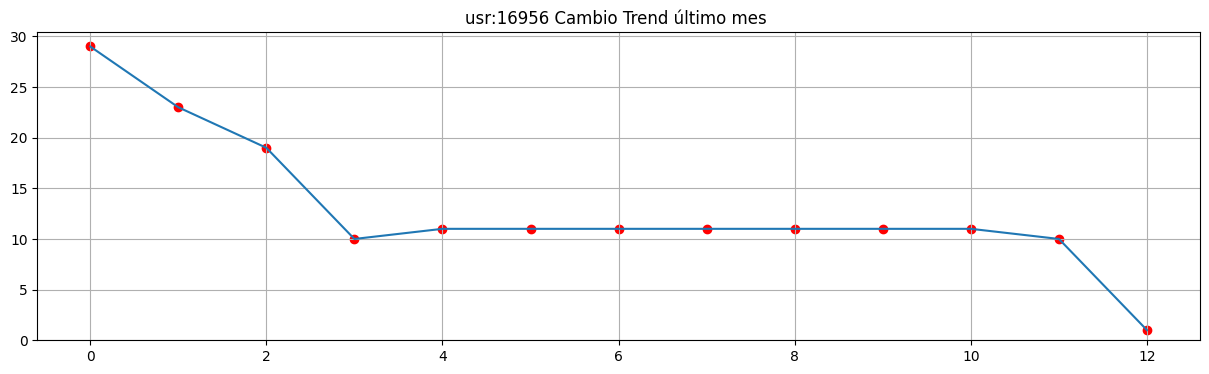

In [17]:
plt.figure(figsize=(15,4))
y = X_test.loc[usr].values
x = range(len(y))
plt.plot(x,y)
plt.scatter(x,y, color='red')
plt.ylim(0.0)
# plt.legend()
plt.grid(True)
plt.title("usr:" + str(usr)+" Cambio Trend último mes ")
plt.show()